In [1]:
import sys
import os
sys.path.append(os.path.abspath("../hyperskin"))

from src.datasets.hsi import HSIDataset
import numpy as np
import torch
import os
import pandas as pd

In [2]:
# cache the dataset arrays to disk for faster reload
cache_dir = "cache"
os.makedirs(cache_dir, exist_ok=True)
imgs_path = os.path.join(cache_dir, "images.npy")
labels_path = os.path.join(cache_dir, "labels.npy")

ds = HSIDataset()

if os.path.exists(imgs_path) and os.path.exists(labels_path):
    images = np.load(imgs_path)
    labels = np.load(labels_path)
else:
    images = np.array([ds[i][0].numpy() for i in range(len(ds))])

    labels = np.array([ds[i][1].numpy() for i in range(len(ds))])
    np.save(imgs_path, images)
    np.save(labels_path, labels)

print(images.shape, labels.shape)

(333, 272, 512, 16) (333,)


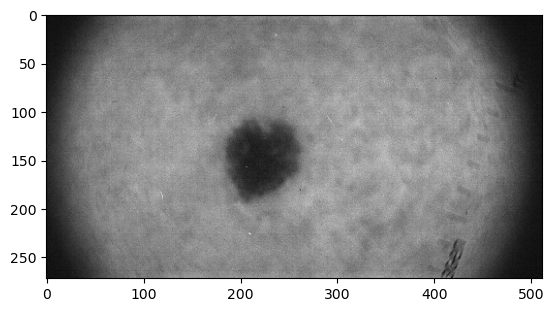

In [3]:

# show one example image. only the image without any border
import matplotlib.pyplot as plt
plt.imshow(images[0, :, :, 0], cmap="gray")
plt.show()

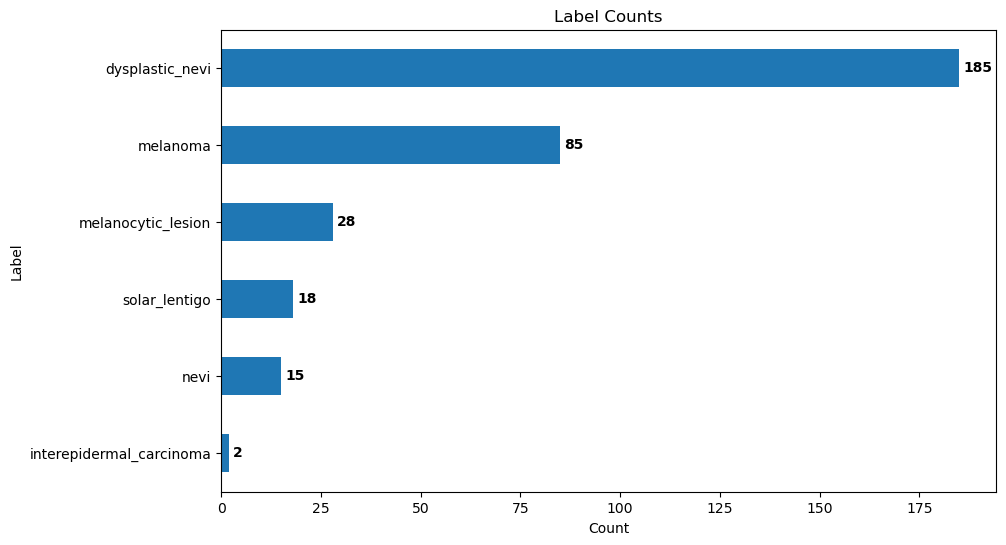

In [4]:
# get value counts of labels 
hsi_df = ds.df

# plot bar chart of label counts with labels on y-axis. add the exact counts on top of each bar
hsi_df['label'].value_counts().sort_values().plot(kind='barh', figsize=(10,6))
import matplotlib.pyplot as plt
for i, v in enumerate(hsi_df['label'].value_counts().sort_values()):
    plt.text(v + 1, i -0.04, str(v), color='black', fontweight='bold')
plt.xlabel("Count")
plt.ylabel("Label")
plt.title("Label Counts")
plt.show()

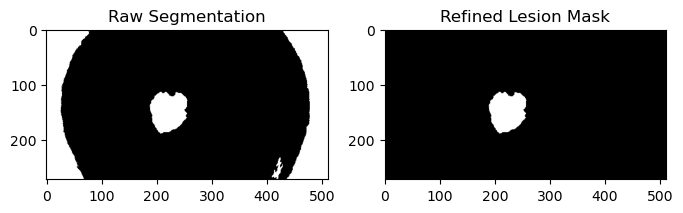

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, morphology, exposure, 
from sklearn.decomposition import PCA
from skimage import measure, morphology, segmentation
import numpy as np

# Example: segment one image
def segment_hsi(img: np.ndarray, n_components: int = 3):
    """
    Segment a hyperspectral image into lesion vs background.
    
    img: (H, W, C) numpy array, dtype float32
    n_components: PCA components to reduce hyperspectral bands

    Returns: binary mask (H, W)
    """

    H, W, C = img.shape
    
    # Flatten pixels -> (N, C)
    flat = img.reshape(-1, C)

    # Normalize per channel (optional, helps with stability)
    flat = (flat - flat.mean(axis=0)) / (flat.std(axis=0) + 1e-8)

    # PCA reduction from 16 → 3
    pca = PCA(n_components=n_components)
    reduced = pca.fit_transform(flat)  # (N, 3)

    # Take the first PC as grayscale for segmentation
    pc1 = reduced[:, 0].reshape(H, W)

    # Contrast stretch
    pc1 = exposure.rescale_intensity(pc1, out_range=(0, 1))

    # Otsu threshold
    thresh = filters.threshold_otsu(pc1)
    mask = pc1 < thresh

    # Morphological cleaning
    mask_clean = morphology.remove_small_objects(mask, min_size=200)
    mask_clean = morphology.remove_small_holes(mask_clean, area_threshold=200)

    return mask_clean.astype(np.uint8), pc1

def refine_mask(mask, min_size=500):
    """
    Refines a binary segmentation mask:
    - clears border artifacts
    - removes small blobs
    - keeps largest connected component
    """
    # Remove border-touching regions (frame artifacts)
    mask = segmentation.clear_border(mask)

    # Remove very small specks
    mask = morphology.remove_small_objects(mask.astype(bool), min_size=min_size)

    # Label connected components
    labeled_mask = measure.label(mask)
    props = measure.regionprops(labeled_mask)

    if len(props) == 0:
        return np.zeros_like(mask, dtype=np.uint8)

    # Keep only the largest component
    largest_region = max(props, key=lambda r: r.area)
    lesion_mask = labeled_mask == largest_region.label

    # Optional: fill small holes inside lesion
    lesion_mask = morphology.remove_small_holes(lesion_mask.astype(bool), area_threshold=1000)

    return lesion_mask.astype(np.uint8)

# Example usage on your dataset
i = 0
img = images[i]
raw_mask, pc1 = segment_hsi(img)

final_mask = refine_mask(raw_mask)

# Visualize
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(raw_mask, cmap="gray"); axs[0].set_title("Raw Segmentation")
axs[1].imshow(final_mask, cmap="gray"); axs[1].set_title("Refined Lesion Mask")
plt.show()

In [6]:
import os
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Make output directory
output_dir = "segmentation_results"
os.makedirs(output_dir, exist_ok=True)

# Iterate over dataset
for i in tqdm(range(len(images)), desc="Processing images"):
    img = images[i]

    # Segment & refine
    raw_mask, _ = segment_hsi(img)
    final_mask = refine_mask(raw_mask)

    # Plot comparison (original first band vs mask)
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(img[:, :, 0], cmap="gray")
    axs[0].axis("off")
    axs[1].imshow(final_mask, cmap="gray")
    axs[1].axis("off")

    # Save to file
    out_path = os.path.join(output_dir, f"comparison_{i:04d}.png")
    plt.savefig(out_path, bbox_inches="tight", pad_inches=0)
    plt.close(fig)

print(f"✅ Saved all comparisons to: {output_dir}")

Processing images: 100%|██████████| 333/333 [00:28<00:00, 11.64it/s]

✅ Saved all comparisons to: segmentation_results


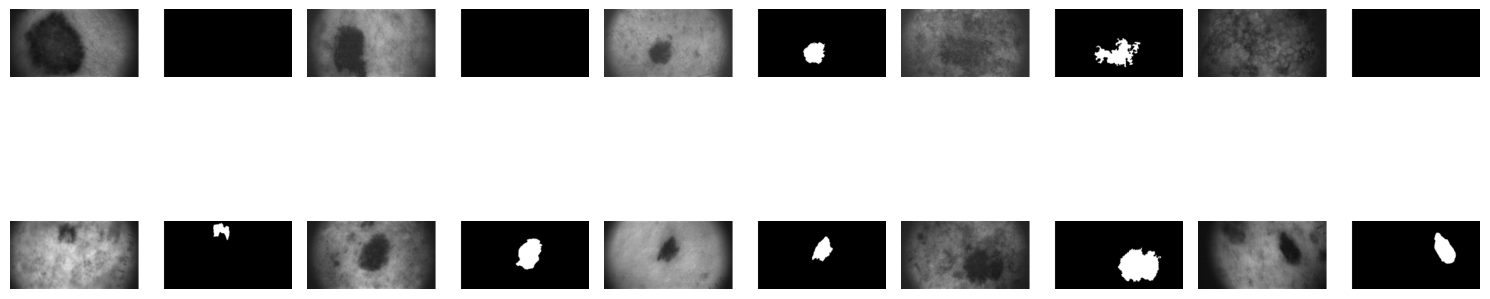

In [7]:
# Pick 10 random images from output_dir
sample_files = random.sample(os.listdir(output_dir), k=10)

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()

for ax, fname in zip(axs, sample_files):
    img = plt.imread(os.path.join(output_dir, fname))
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()